In [466]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve
import pandas as pd

In [467]:
# generate the heterotopic data
# partial heterotopic: some input x is similar, some not in two set

def f1(x):
    return np.sin(x)

def f2(x):
    return np.cos(2 * x)

# generate input data

# 50 samples for y1
X1 = np.sort(np.random.choice(np.linspace(0, 2* np.pi, 100), size=70, replace=False)).reshape(-1,1)

# 30 sample for the y2
X2 = np.sort(np.random.choice(np.linspace(0, 2* np.pi, 100), size=50, replace=False)).reshape(-1,1)

#sampling test point

X_pool = np.linspace(0.1, 3 * np.pi, 400)
X_test = np.sort(np.random.choice(X_pool, size=200, replace=False)).reshape(-1, 1)

In [468]:
# test the overlap and diff X1, X2
X1_test = np.sort(np.random.choice(np.linspace(0, 2* np.pi, 100), size=50, replace=False))
X2_test = np.sort(np.random.choice(np.linspace(0, 2* np.pi, 100), size=30, replace=False))
diff = list(set(X1_test) - set(X2_test))
diff

[0.5077321460347141,
 0.6346651825433925,
 1.3327968833411243,
 0.3173325912716963,
 1.0789308103237674,
 1.3962634015954636,
 1.4597299198498028,
 2.3482611754105527,
 2.4117276936648917,
 2.8559933214452666,
 3.3637254674799806,
 3.8714576135146945,
 4.188790204786391,
 4.25225672304073,
 5.204254496855819,
 6.092785752416569,
 4.3791897595494085,
 4.696522350821105,
 4.759988869075444,
 4.823455387329783,
 6.219718788925247,
 0.06346651825433926,
 2.53866073017357,
 3.42719198573432,
 3.490658503988659,
 0.12693303650867852,
 2.1578616206475347,
 4.6330558325667655,
 1.71359599286716,
 4.950388423838462,
 5.013854942092801,
 5.458120569873176,
 1.7770625111214993,
 2.221328138901874,
 2.284794657156213,
 2.729060284936588,
 3.744524577006016]

In [469]:
np.array(diff).shape

(37,)

In [470]:
# ensure no overlaping between the training and testing point
a = np.linspace(0, 2* np.pi, 200)
b = np.linspace(0.1, 4 * np.pi, 300)
c = set(a) & set(b)
c

set()

In [471]:
# getting the training function value for both output
f1_x1_train = f1(X1).flatten()
f2_x1_train = f2(X1).flatten()

f1_x2_train = f1(X2).flatten()
f2_x2_train = f2(X2).flatten()

#test data
f1_test = f1(X_test).flatten()
f2_test = f2(X_test).flatten()

In [472]:
# assume there are sharing structure between two output we can just generate it

## mixing assumtion
A_mixing = np.array([[1.0, -0.5],
                   [0.8, 0.7]])

#noise
sigma1, sigma2 = 0.1, 0.1

In [473]:
A_mixing

array([[ 1. , -0.5],
       [ 0.8,  0.7]])

In [474]:
# generate the training label and ground truth for the test

y1_train = A_mixing[0, 0] * f1_x1_train + A_mixing[0, 1] * f2_x1_train + np.random.normal(0, sigma1, size=f1_x1_train.shape)
y2_train = A_mixing[1, 0] * f1_x2_train + A_mixing[1, 1] * f2_x2_train + np.random.normal(0, sigma1, size=f2_x2_train.shape)

# test
y1_test = A_mixing[0, 0] * f1_test + A_mixing[0, 1] * f2_test
y2_test = A_mixing[1, 0] * f1_test + A_mixing[1, 1] * f2_test

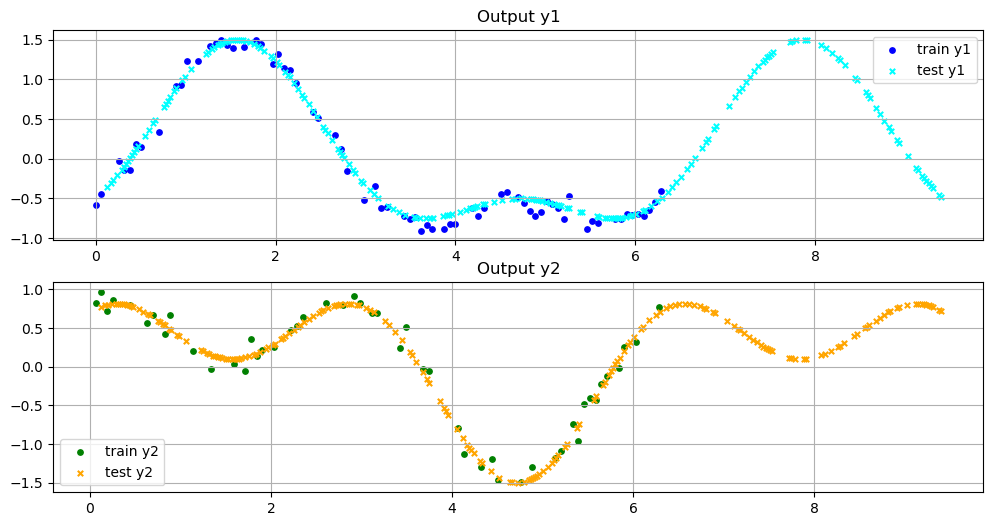

In [475]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("Output y1")
plt.scatter(X1, y1_train, color="blue", label="train y1", s=15)
plt.scatter(X_test, y1_test, color="cyan", label="test y1", s=15, marker="x")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title("Output y2")
plt.scatter(X2, y2_train, color="green", label="train y2", s=15)
plt.scatter(X_test, y2_test, color="orange", label="test y2", s=15, marker="x")
plt.grid(True)
plt.legend()

In [476]:
# define the kernel function

def periodic_kernel(X1, X2, lengthscale, variance, period):
  X_1 = np.atleast_2d(X1).reshape(-1, 1)
  X_2 = np.atleast_2d(X2).reshape(-1, 1)
  dists = np.abs(X1 - X2.T)
  sin_term = np.sin(np.pi * dists / period)
  return variance**2 * np.exp(-2 * (sin_term**2) / lengthscale**2)

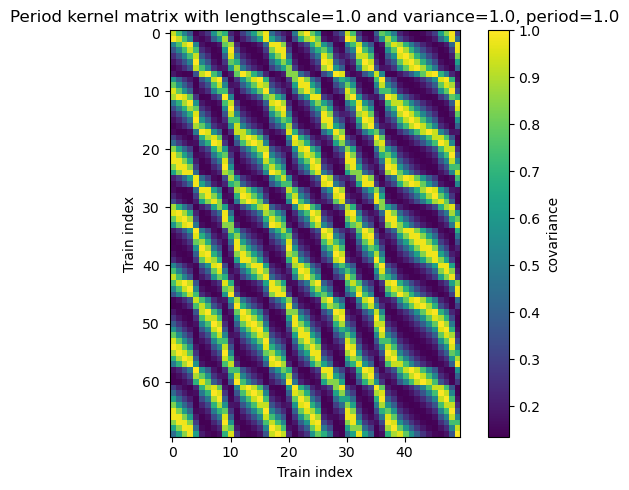

In [477]:
#test the periodic kernel

cov_matrix = periodic_kernel(X1, X2, 1.0, 1.0, 1.0)

plt.figure(figsize=(6,5))
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Period kernel matrix with lengthscale=1.0 and variance=1.0, period=1.0")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [478]:
## define the covariance matrix block wise => This is hard code for this problem when we have two function output
## K_full = [K11 K12]
##          [K21 K22]

def slfm_heterotopic_kernel_full(X1, X2, A, kernel_params, sigma1, sigma2):
    N1 = X1.shape[0]
    N2 = X2.shape[0]

    Q = len(kernel_params)
    K_full = np.zeros((N1 + N2, N1 + N2)) #size of the full covariance matrix

    for q in range(Q):
        
        # calculate block covariance matrix
        K11_q = periodic_kernel(X1, X1, **kernel_params[q])
        K22_q = periodic_kernel(X2, X2, **kernel_params[q])
        K12_q = periodic_kernel(X1, X2, **kernel_params[q])
        K21_q = K12_q.T

        A1q, A2q = A[0, q], A[1, q]

        # calculate each block row of the covariance matrix
        top = np.hstack([A1q**2 * K11_q, A1q * A2q * K12_q])
        bottom = np.hstack([A2q * A1q * K21_q, A2q**2 * K22_q])

        K_q = np.vstack([top, bottom])

        K_full += K_q

    # add noise for each output (diagonal)
    K_full += np.diag(np.concatenate([np.full(N1, sigma1**2), np.full(N2, sigma2**2)]))

    return K_full
    

In [479]:
# test the cov_func
slfm_heterotopic_cov_matrix = slfm_heterotopic_kernel_full(X1, X2, A_mixing, 
                                                           [{'lengthscale': 1.0, 'variance': 1.0, 'period': 1.0},
                                                           {'lengthscale': 1.0, 'variance': 1.0, 'period': 1.0}]
                                                           , 0.1, 0.1)

In [480]:
slfm_heterotopic_cov_matrix.shape

(120, 120)

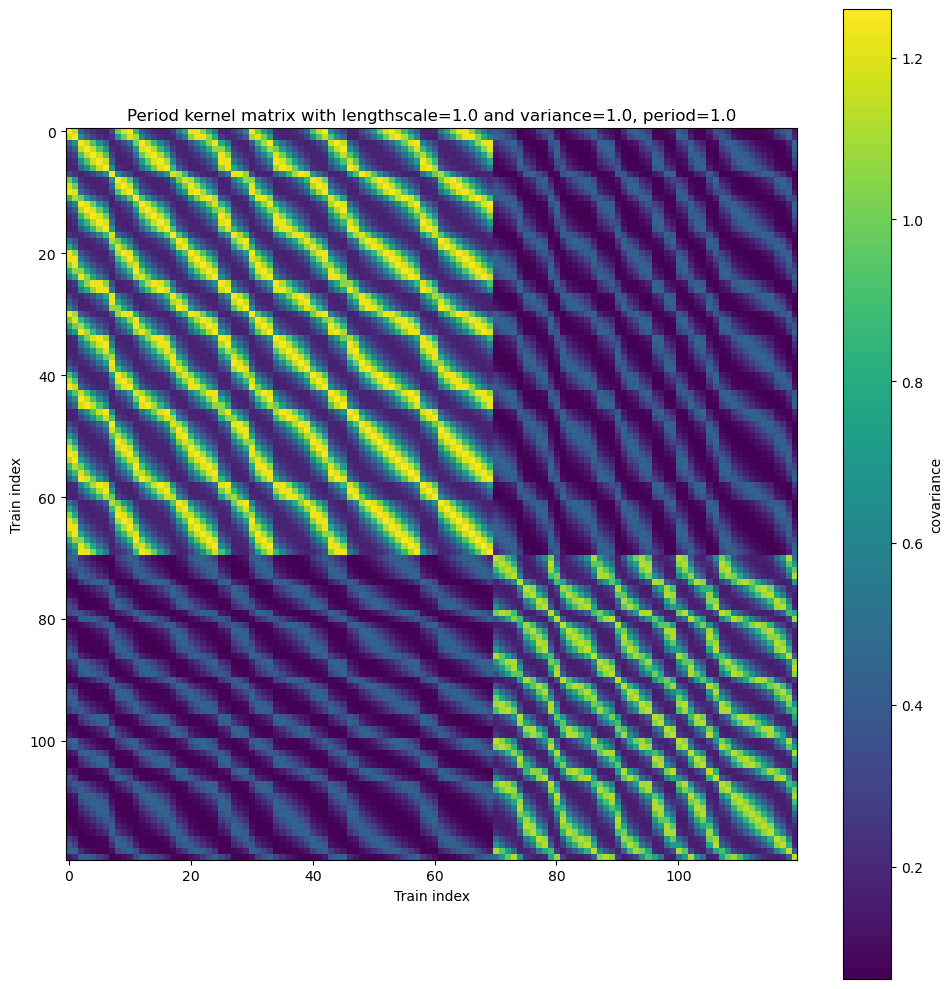

In [481]:
plt.figure(figsize=(10,10))
plt.imshow(slfm_heterotopic_cov_matrix, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Period kernel matrix with lengthscale=1.0 and variance=1.0, period=1.0")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [482]:
# define the log-marginal likelihood

def log_mll(params, X1, X2, y1, y2, Q=2):
    
    Y = np.concatenate([y1, y2]).reshape(-1, 1) #convert the label to col vector

    #get params
    A = params[:Q*2].reshape(2, Q) #get the params for the mixing matrix and reshape to the form of the matrix

    kernels_params = []
    idx = Q*2

    for _ in range(Q):
        lengthscale = np.exp(params[idx])
        variance = np.exp(params[idx + 1])
        period = np.exp(params[idx + 2])
        
        # adding the set of hyperparams for appropriate kernel
        kernels_params.append({'lengthscale': lengthscale, 'variance': variance, 'period': period})
        idx += 3

    # getting the variance for noise
    sigma1 = np.exp(params[idx])
    sigma2 = np.exp(params[idx+1])

    #compute the full kernel
    K = slfm_heterotopic_kernel_full(X1, X2, A, kernels_params, sigma1, sigma2)

    #compute the lml -> return the negative log marginal likelihood
    try:
        L, lower = cho_factor(K + 1e-6 * np.eye(K.shape[0])) ## add jiter for stable and prevent the matrix become singular
        alpha = cho_solve((L, lower), Y)
        logdet = 2 * np.sum(np.log(np.diag(L)))
        N = Y.shape[0]
        lml = -0.5 * Y.T @ alpha - 0.5 * logdet - 0.5 * N * np.log(2 * np.pi)
        return -lml.flatten()[0]

    except np.linalg.LinAlgError:
        return 1e10


In [555]:
init_A = np.random.randn(2 * 2)
init_kernels = np.log([2.0, 2.0, np.pi] * 2)
init_noise = np.log([0.1, 0.1])
init_params = np.concatenate([init_A, init_kernels, init_noise])

bounds = []

# A (mixing matrix): unconstrained but keep within reasonable values
bounds += [(None, None)] * 4

bounds += [
    (np.log(0.1), None),  # lengthscale q1
    (np.log(0.1), None), # variance q1
    (np.log(0.1), 20.0),  # period q1
    (np.log(0.1), None),  # lengthscale q2
    (np.log(0.1), None), # variance q2
    (np.log(0.1), 20.0),  # period q2
]

# noise log-variance bounds
bounds += [(np.log(1e-2), np.log(2.0))] * 2

# optimize
res = minimize(log_mll, init_params, args=(X1, X2, y1_train, y2_train), method='L-BFGS-B', bounds=bounds)


In [557]:
lml = -res.fun
lml

-126.06987656817674

In [559]:
# unpack best params
opt_params = res.x
A_opt = opt_params[:4].reshape(2, 2)
kernel_params_opt = []
idx = 4

for _ in range(2):
    l = np.exp(opt_params[idx])
    v = np.exp(opt_params[idx+1])
    p = np.exp(opt_params[idx+2])
    kernel_params_opt.append({'lengthscale': l, 'variance': v, 'period': p})
    idx += 3
    
sigma1_opt = np.exp(opt_params[idx])
sigma2_opt = np.exp(opt_params[idx+1])

In [561]:
sigma1_opt


0.7443936961538093

In [563]:
sigma2_opt

0.553273800664956

In [565]:
A_opt

array([[-3.77559756e-01, -1.14181867e-06],
       [ 5.12683959e-01,  1.38639747e-06]])

In [567]:
kernel_params_opt

[{'lengthscale': 1.0999251653186175,
  'variance': 1.047053594820216,
  'period': 3.1665329613891515},
 {'lengthscale': 2.11231086308467,
  'variance': 1.8103677992002907,
  'period': 2.7169480059660462}]

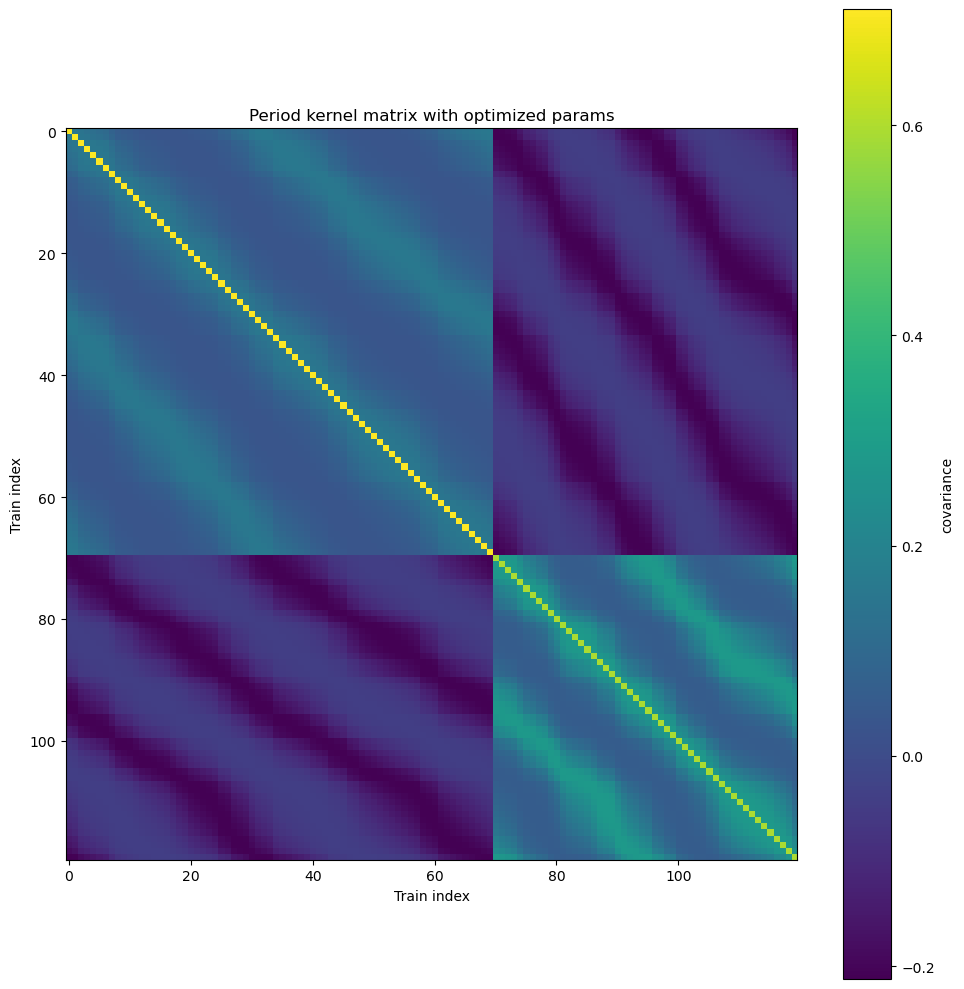

In [569]:
opt_kernel_mtr = slfm_heterotopic_kernel_full(X1, X2, A_opt, kernel_params_opt, sigma1_opt, sigma2_opt)

plt.figure(figsize=(10,10))
plt.imshow(opt_kernel_mtr, cmap='viridis')
plt.colorbar(label='covariance')
plt.title(f"Period kernel matrix with optimized params")
plt.xlabel("Train index")
plt.ylabel("Train index")
plt.tight_layout()
plt.show()

In [549]:
opt_kernel_mtr

array([[ 0.7103883 ,  0.15526633,  0.14103639, ..., -0.15978132,
        -0.18346855, -0.21136662],
       [ 0.15526633,  0.7103883 ,  0.14743646, ..., -0.14711398,
        -0.17205405, -0.20785337],
       [ 0.14103639,  0.14743646,  0.7103883 , ..., -0.11055067,
        -0.13446737, -0.18346855],
       ...,
       [-0.15978132, -0.14711398, -0.11055067, ...,  0.59429481,
         0.28075859,  0.23012779],
       [-0.18346855, -0.17205405, -0.13446737, ...,  0.28075859,
         0.59429481,  0.26005793],
       [-0.21136662, -0.20785337, -0.18346855, ...,  0.23012779,
         0.26005793,  0.59429481]])

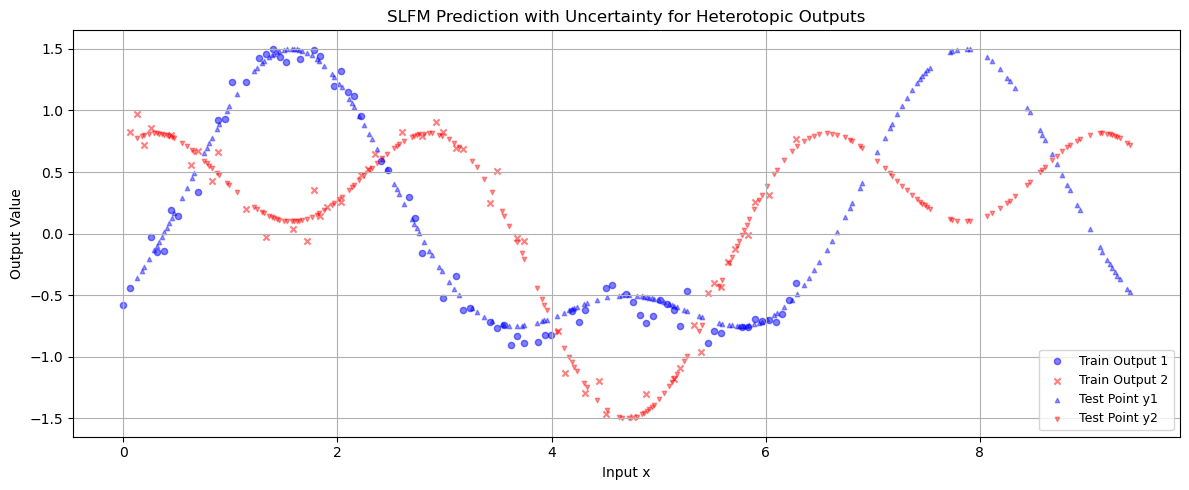

In [529]:

fig, ax = plt.subplots(figsize=(12, 5))
X_test_flat = X_test.flatten()

ax.scatter(X1, y1_train, color="blue", s=20, label="Train Output 1", alpha=0.5, marker='o')
ax.scatter(X2, y2_train, color="red", s=20, label="Train Output 2", alpha=0.5, marker='x')
ax.scatter(X_test, y1_test, color="blue", s=10, label="Test Point y1", alpha=0.4, marker='^')
ax.scatter(X_test, y2_test, color="red", s=10, label="Test Point y2", alpha=0.4, marker='v')

ax.set_title("SLFM Prediction with Uncertainty for Heterotopic Outputs")
ax.set_xlabel("Input x")
ax.set_ylabel("Output Value")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True)
plt.tight_layout()
plt.show()